In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import open3d as o3d
import os
import matplotlib.pyplot as plt
import yaml
from scipy.signal import savgol_filter, find_peaks, peak_widths
from concurrent.futures import ProcessPoolExecutor

import wire_detection_utils as wdu
import viz_utils as vu

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
with open('wire_detect_config.yaml', 'r') as file:
    detection_config = yaml.safe_load(file)


line_threshold = detection_config['line_threshold']
pixel_binning_size = detection_config['pixel_binning_size']
low_canny_threshold = detection_config['low_canny_threshold']
high_canny_threshold = detection_config['high_canny_threshold']
bin_avg_threshold_multiplier = detection_config['bin_avg_threshold_multiplier']
value_threshold = detection_config['value_threshold']

input_image_size = [480, 270]

# Creat e a WireDetector instance
wire_detector = wdu.WireDetector(line_threshold, low_canny_threshold, high_canny_threshold, pixel_binning_size, bin_avg_threshold_multiplier)

folder = '/media/tyler/Storage/Research/Datasets/wire_tracking_05-07_40fov/'
# folder = '/media/tyler/Storage/field_tests/street_wire_experiments/wire_tracking_05-07_40fov/'
# target_timestamp = 1746650652972994304 # straight wire
target_timestamp = 1746650656862302432 # angled wire
# folder = '/media/tyler/Storage/field_tests/acfa_3-21/'
# target_timestamp = 1742581588251564064

rgb_folder = folder + 'rgb_images/'
depth_folder = folder + 'depth_images/'
camera_intrinsics_file = folder + 'rgb_camera_intrinsics.npy'
camera_intrinsics = np.load(camera_intrinsics_file)

closest_rgb_timestamp = None
closest_depth_timestamp = None
for image_name in os.listdir(rgb_folder):
    if image_name.endswith('.png'):
        timestamp = int(image_name.split('.')[0])
        if closest_rgb_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_rgb_timestamp - target_timestamp):
            closest_rgb_timestamp = timestamp
for image_name in os.listdir(depth_folder):
    if image_name.endswith('.npy'):
        timestamp = int(image_name.split('.')[0])
        if closest_depth_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_depth_timestamp - target_timestamp):
            closest_depth_timestamp = timestamp

rgb_image_path = str(closest_rgb_timestamp) + '.png'
depth_image_path = str(closest_depth_timestamp) + '.npy'

print(f"Time difference between closest RGB and depth images: {abs(closest_rgb_timestamp - closest_depth_timestamp)}")
    
img = cv2.imread(rgb_folder + rgb_image_path)
depth = np.load(depth_folder + depth_image_path)
assert img is not None, "Image not found"
assert depth is not None, "Depth image not found"

Time difference between closest RGB and depth images: 2445376


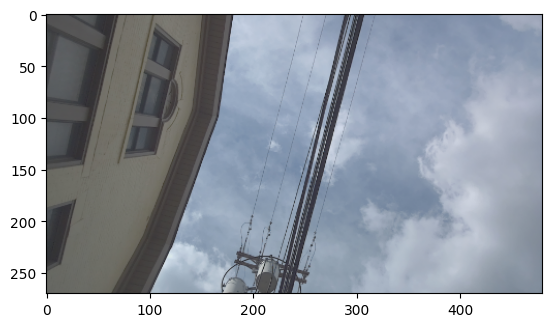

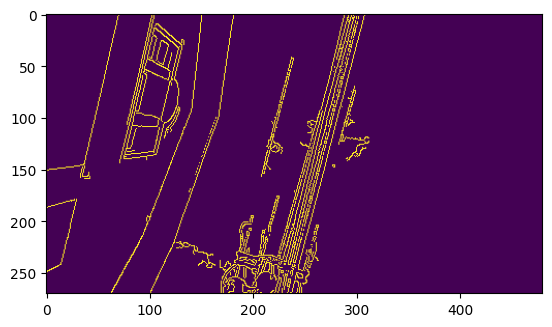

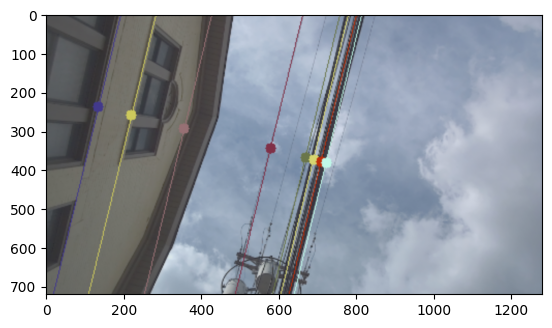

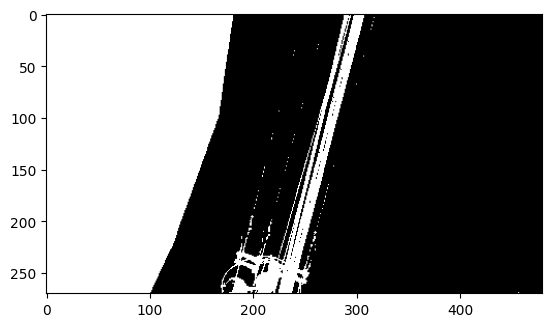

In [3]:
# img = cv2.resize(img, (input_image_size[0], input_image_size[1]))
# depth = cv2.resize(depth, (input_image_size[0], input_image_size[1]))
cv2.imwrite('detect_3d_output/reference.jpg', img)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Create segmentation mask
seg_mask = wire_detector.create_seg_mask(img)
cv2.imwrite('detect_3d_output/seg_mask.jpg', seg_mask)
plt.figure()
plt.imshow(seg_mask)

wire_lines, wire_midpoints, avg_angle, midpoint_dists_wrt_center = wire_detector.detect_wires_2d(seg_mask)

img_2d_detect = img.copy()
rand_colors = np.random.randint(0, 256, (len(wire_midpoints), 3)).tolist()
for i, (x0,y0,x1,y1) in enumerate(wire_lines):
    cv2.line(img_2d_detect, (x0,y0), (x1,y1), tuple(rand_colors[i]), 1)

for i, (x0,y0) in enumerate(wire_midpoints):
    cv2.circle(img_2d_detect, (int(x0), int(y0)), 5, tuple(rand_colors[i]), -1)
img_2d_detect = cv2.resize(img_2d_detect, (1280, 720))
cv2.imwrite('detect_3d_output/wire2d_detect.jpg', img_2d_detect)
plt.figure()
plt.imshow(cv2.cvtColor(img_2d_detect, cv2.COLOR_BGR2RGB))

# create value mask
lower_black = np.array([0, 0, 0])
upper_black = np.array([150,150,150])
v_mask = cv2.inRange(img, lower_black, upper_black)
plt.figure()
plt.imshow(v_mask, cmap='gray')

Start indices: [  3  64  69  90 112 125 134]
End indices: [ 28  68  88 108 124 132 153]


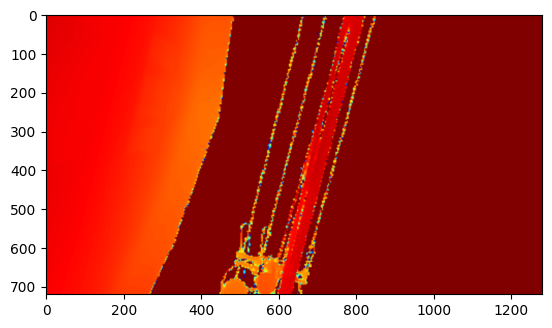

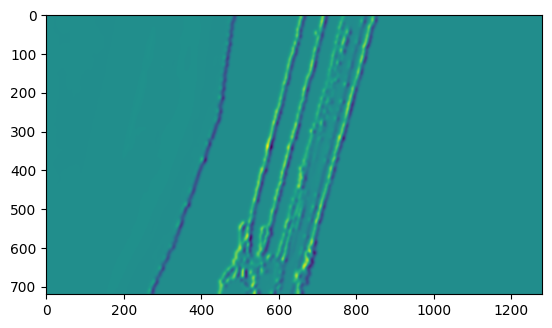

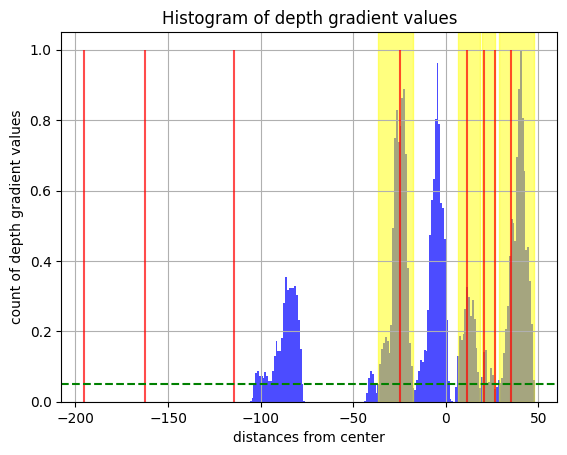

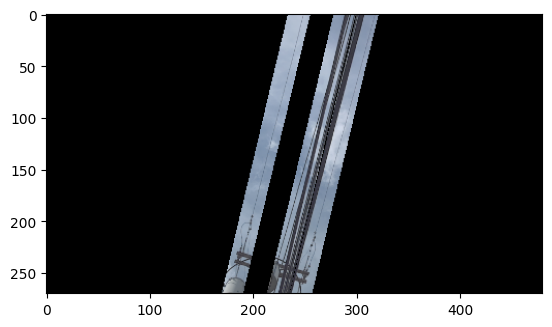

In [4]:
min_depth = 0.5
depth[depth <= min_depth] = 0

depth_viz = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
depth_viz = cv2.applyColorMap(depth_viz, cv2.COLORMAP_JET)
depth_viz = cv2.resize(depth_viz, (1280, 720))
cv2.imwrite('detect_3d_output/depth_viz.jpg', depth_viz)
plt.figure()
plt.imshow(depth_viz)

depth_gradient_x = cv2.Sobel(depth, cv2.CV_64F, 1, 0, ksize=11)
depth_gradient_y = cv2.Sobel(depth, cv2.CV_64F, 0, 1, ksize=11)
perp_angle = wdu.perpendicular_angle_rad(avg_angle)
depth_gradient = depth_gradient_x * np.cos(perp_angle) + depth_gradient_y * np.sin(perp_angle)
# depth_gradient = np.sqrt(depth_gradient_x**2 + depth_gradient_y**2)
depth_gradient_viz = cv2.normalize(depth_gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
depth_gradient_viz = cv2.resize(depth_gradient_viz, (1280, 720))
cv2.imwrite('detect_3d_output/depth_gradient.jpg', depth_gradient_viz)
plt.figure()
plt.imshow(depth_gradient_viz)

distance, depth_gradient_1d = wdu.project_image_to_axis(depth_gradient, perp_angle)
depth_gradient_1d = np.abs(depth_gradient_1d)
depth_gradient_1d = depth_gradient_1d / np.max(depth_gradient_1d)
depth_gradient_1d_shortened = depth_gradient_1d[depth_gradient_1d > 0.2]
distance_shortened = distance[depth_gradient_1d > 0.2]

dist_hist, bin_edges = np.histogram(distance_shortened, bins=np.arange(np.min(distance_shortened), np.max(distance_shortened), 1), weights=depth_gradient_1d_shortened)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
dist_hist = dist_hist / np.max(dist_hist)

threshold = bin_avg_threshold_multiplier * np.mean(dist_hist)
mask = dist_hist > threshold
mask_diff = np.diff(mask.astype(int))
mask_diff = np.concatenate(([0], mask_diff))

start_indices = np.where(mask_diff == 1)[0]
end_indices = np.where(mask_diff == -1)[0]
if len(start_indices) > len(end_indices):
    end_indices = np.append(end_indices, len(mask) - 1)
if len(end_indices) > len(start_indices):
    start_indices = np.append(0, start_indices)
    
assert len(start_indices) == len(end_indices), "Mismatch in start and end indices length"


regions_of_interest = []
print(f"Start indices: {start_indices}")
print(f"End indices: {end_indices}")
for start, end in zip(start_indices, end_indices):
    if bin_centers[start] < bin_centers[end]:
        start = bin_centers[start]
        end = bin_centers[end]
        for wire_dist in midpoint_dists_wrt_center: 
            if start <= wire_dist <= end:
                # Check if the region is valid
                if (start < end) and (end - start > 1):
                    # Append the region to the list
                    regions_of_interest.append((start, end))
                    break

plt.figure()
plt.bar(bin_centers, dist_hist, width=1, color='blue', alpha=0.7)
plt.vlines(midpoint_dists_wrt_center, min(dist_hist), max(dist_hist), color='red', alpha=0.7, label='wire midpoints')
for start, end in regions_of_interest:
    plt.axvspan(start, end, color='yellow', alpha=0.5, label='ROI')
plt.axhline(y=threshold, color='green', linestyle='--', label='ROI mask')
plt.title('Histogram of depth gradient values')
plt.xlabel('distances from center')
plt.ylabel('count of depth gradient values')
plt.grid()
plt.savefig('detect_3d_output/histogram_neg.png')
plt.show()

roi_depths, depth_masked, roi_rgb, rgb_masked = wdu.roi_to_mask(regions_of_interest, perp_angle, depth, img)
cv2.imwrite('detect_3d_output/rgb_masked.jpg', rgb_masked)
plt.figure()
plt.imshow(cv2.cvtColor(rgb_masked, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
#run ransac line fitting on sections of the point cloud
start_time = time.perf_counter()
fitted_lines = []
roi_pcs = []
roi_point_colors = []
inv_camera_intrinsics = np.linalg.inv(camera_intrinsics)
for roi_depth, roi_rgb in zip(roi_depths, roi_rgb):
    # convert depth image to point cloud
    points, colors = wdu.depth_to_pointcloud(roi_depth, camera_intrinsics, roi_rgb)
    roi_pcs.append(points)
    colors = (np.array(colors) / 255.0)[:,::-1]
    roi_point_colors.append(colors)
    line = wdu.ransac_line_fitting(points, avg_angle, num_iterations=300, inlier_threshold=0.0508, vert_angle_thresh=np.pi/30, horiz_angle_thresh=np.pi/10)
    fitted_lines.append(line)
end_time = time.perf_counter()
print(f"Time taken for RANSAC line fitting: {end_time - start_time:.2f} seconds, {1 / (end_time - start_time):.2f} Hz")

# visualize the fitted lines


Time taken for RANSAC line fitting: 0.04 seconds, 28.20 Hz


In [6]:
# visualize the fitted lines
geometries = []
for fitted_line, points, colors in zip(fitted_lines, roi_pcs, roi_point_colors):
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    geometries.append(point_cloud)
    cylinder = vu.create_cylinder_between_points(fitted_line[0], fitted_line[1], radius=0.05)
    geometries.append(cylinder)

o3d.visualization.draw_geometries(geometries, window_name="Fitted Lines", width=1280, height=720, left=50, top=50, mesh_show_back_face=True)
    

In [7]:
# visualize point cloud from depth image


depth_image = np.load(depth_folder + depth_image_path)
min_depth = 0.5
depth_image[depth_image <= min_depth] = 0

rgb_img = cv2.imread(rgb_folder + rgb_image_path)

intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=rgb_img.shape[1],
    height= rgb_img.shape[0],
    fx=camera_intrinsics[0, 0],
    fy=camera_intrinsics[1, 1],
    cx=camera_intrinsics[0, 2],
    cy=camera_intrinsics[1, 2]
)

camera_intrinsics = np.load(camera_intrinsics_file)

# Convert depth image to Open3D format
depth_o3d = o3d.geometry.Image(depth_image.astype(np.float32))


# Create an Open3D RGBD image
rgb_o3d = o3d.geometry.Image(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color=rgb_o3d,
    depth=depth_o3d,
    depth_scale=1.0,  # Adjust based on your depth scale
    depth_trunc=10.0,  # Truncate depth values beyond this distance
    convert_rgb_to_intensity=False
)

# Create a pinhole camera intrinsic object
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=input_image_size[0],
    height=input_image_size[1],
    fx=camera_intrinsics[0, 0],
    fy=camera_intrinsics[1, 1],
    cx=camera_intrinsics[0, 2],
    cy=camera_intrinsics[1, 2]
)

point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    intrinsics
)

# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud], point_show_normal=True)
